In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input, BatchNormalization, Activation, MaxPooling2D, Add
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

## prepare data

In [2]:
# Load the data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

# free some space
del train 

#g = sns.countplot(Y_train)
#Y_train.value_counts()

In [4]:
# Prepare data:

X_train = X_train / 255.0
test = test / 255.0
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

Y_train = to_categorical(Y_train, num_classes = 10)

random_seed = 2
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state=random_seed)

In [5]:
# Visualize data:

#g = plt.imshow(X_train[250][:,:,0])


## Build and traing model

In [18]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [21]:
X_input=Input(shape=(28, 28, 1))

X_shortcut = X_input
X_shortcut = Conv2D(32, (1, 1), strides = (1, 1), padding='valid', name = 'shortcut1')(X_shortcut)
X = Conv2D(32, (5, 5), strides = (1, 1), padding='same', name = 'conv1')(X_input)
X = BatchNormalization(axis = 1, epsilon=0.00001, name = 'b1')(X)
X = Dropout(0.25)(X)
X = Activation('relu')(X)

X = Conv2D(32, (3, 3), strides = (1, 1), padding='same', name = 'conv2')(X)
X = BatchNormalization(axis = 1, epsilon=0.00001, name = 'b2')(X)
X = Dropout(0.25)(X)
X = Add()([X,X_shortcut])
X = Activation('relu')(X)
X = MaxPooling2D(pool_size=2, strides=2)(X)

X_shortcut = X
X_shortcut = Conv2D(64, (1, 1), strides = (1, 1), padding='valid', name = 'shortcut2')(X_shortcut)
X = Conv2D(64, (3, 3), strides = (1, 1), padding='same', name = 'conv3')(X)
X = BatchNormalization(axis = 1, epsilon=0.00001, name = 'b3')(X)
X = Dropout(0.25)(X)
X = Activation('relu')(X)

X = Conv2D(64, (3, 3), strides = (1, 1), padding='same', name = 'conv4')(X)
X = BatchNormalization(axis = 1, epsilon=0.00001, name = 'b4')(X)
X = Dropout(0.25)(X)
X = Add()([X,X_shortcut])
X = Activation('relu')(X)
X = MaxPooling2D(pool_size=2, strides=2)(X)

X_shortcut = X
X_shortcut = Conv2D(128, (1, 1), strides = (1, 1), padding='valid', name = 'shortcut3')(X_shortcut)
X = Conv2D(128, (3, 3), strides = (1, 1), padding='same', name = 'conv5')(X)
X = BatchNormalization(axis = 1, epsilon=0.00001, name = 'b5')(X)
X = Dropout(0.25)(X)
X = Activation('relu')(X)

X = Conv2D(128, (3, 3), strides = (1, 1), padding='same', name = 'conv6')(X)
X = BatchNormalization(axis = 1, epsilon=0.00001, name = 'b6')(X)
X = Dropout(0.25)(X)
X = Add()([X,X_shortcut])
X = Activation('relu')(X)
X = MaxPooling2D(pool_size=2, strides=2)(X)

X_shortcut = X
X_shortcut = Conv2D(256, (1, 1), strides = (1, 1), padding='valid', name = 'shortcut4')(X_shortcut)
X = Conv2D(256, (3, 3), strides = (1, 1), padding='same', name = 'conv7')(X)
X = BatchNormalization(axis = 1, epsilon=0.00001, name = 'b7')(X)
X = Dropout(0.25)(X)
X = Activation('relu')(X)

X = Conv2D(256, (3, 3), strides = (1, 1), padding='same', name = 'conv8')(X)
X = BatchNormalization(axis = 1, epsilon=0.00001, name = 'b8')(X)
X = Dropout(0.25)(X)
X = Add()([X,X_shortcut])
X = Activation('relu')(X)
X = MaxPooling2D(pool_size=2, strides=2)(X)

X = Flatten()(X)
X = Dense(256,activation='relu')(X)
X = Dropout(0.5)(X)
X = Dense(10,activation='softmax')(X)

model = Model(inputs=X_input, outputs=X)

# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# Compile the model
model.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

#callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 28, 28, 32)   832         input_14[0][0]                   
__________________________________________________________________________________________________
b1 (BatchNormalization)         (None, 28, 28, 32)   112         conv1[0][0]                      
__________________________________________________________________________________________________
dropout_48 (Dropout)            (None, 28, 28, 32)   0           b1[0][0]                         
__________________________________________________________________________________________________
activation

In [ ]:
epochs = 100 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
"""
history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
                    validation_data = (X_val, Y_val), verbose = 1)
"""

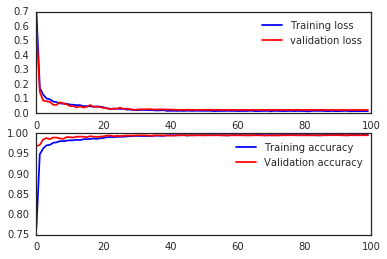

In [21]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [22]:
# Save model and hostory:
basename="basemodel_4CNN_1Dense_norm_"+str(epochs)+"epochs"
historydata = pd.DataFrame.from_dict(history.history)
historydata.to_csv(basename+"-history.csv")
#model.save(basename+"-model.h5")

# serialize model to JSON
model_json = model.to_json()
with open(basename+"-model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(basename+"-weights.h5")
print("Saved model to disk")


Saved model to disk


In [23]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv(basename+"-submission.csv",index=False)

## Next couple of cells are for analyzing data

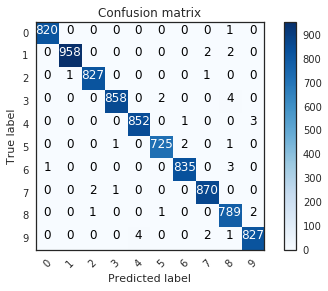

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))